In [1]:
import math
import pandas_datareader as web
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

plt.style.use ('fivethirtyeight')

Primero obtenemos el Dataframe de pandas que nos proporciona el API de yahoo finance de la acción AAPl (Apple) desde 2012 hasta la actualidad

In [2]:
#fecha de hoy
today = str(datetime.today().year)+"-"+str(datetime.today().month)+"-"+str(datetime.today().day)


df = web.DataReader('AAPL',data_source='yahoo', start='2012-01-01', end = today)
df


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.610317
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.678083
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.818838
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.952844
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.932294
...,...,...,...,...,...,...
2021-10-15,144.899994,143.509995,143.770004,144.839996,67885200.0,144.839996
2021-10-18,146.839996,143.160004,143.449997,146.550003,85589200.0,146.550003
2021-10-19,149.169998,146.550003,147.009995,148.759995,76378900.0,148.759995


Text(0, 0.5, 'Close Price USD ($)')

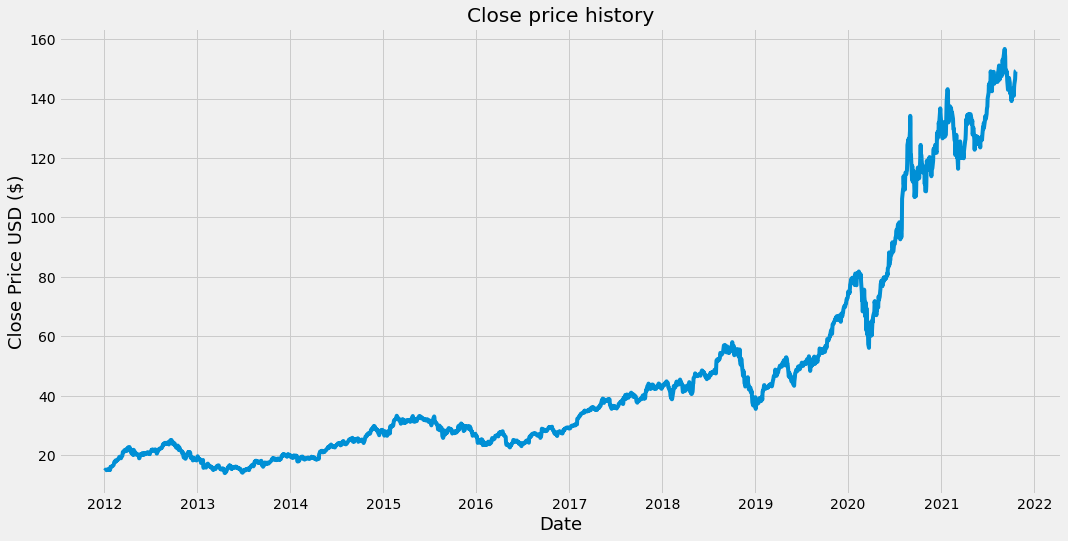

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close price history')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)


Ahora necesitamos definir la cantidad de valores que se van a usar para tanto el entrenamiento de la red neural, como para probar, para este caso va a ser un 80% para entrenamiento


Filtramos por la columna 'close' del dataframe que es la que vamos a utilizar para las predicciones

In [4]:

dataset = df.filter(['Close']).values

train_data_len = math.ceil(len(dataset) * 0.8)
train_data_len

1975

Necesitamos escalar los datas para que esten en un rango entre $(0,1)$

In [5]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00517915],
       [0.00573209],
       [0.00688052],
       ...,
       [0.94444536],
       [0.94794817],
       [0.94840356]])

Ahora creamos un dataset de entrenamiento, en base a los datos escalados en el rango definido anteriormente ($90\%$)

Para esto creamos la matriz x_train y el arreglo y_train

x_train: es una matriz con las últimas 100 posiciones del dataset, en este caso, el comportamiento de la acción en los últimos 100 días

y_train, es su espejo en el eje y, es decir si fueramos a graficar, cuando se tiene un patrón de comportamiento parecido a los úlimos 100 días, se llega al valor de y_train[i]


In [6]:
train_data = scaled_data[0:train_data_len,:]

x_train = []
y_train = []

for i in range (100,len(train_data)):
    x_train.append(train_data[i-100:i, 0])
    y_train.append(train_data[i , 0])





Los convertimos en arreglos de numpy

Y posteriormente hacemos un 'reshape' que es básicamente convertir los datos que tenemos en 2 dimensiones a 3 dimensiones ya que de esta manera funcionan las redes reuronales de tensorflow, por lo que añadimos una dimensión más con un 1 constante

In [7]:

#convertir listas a arreglos numpy
x_train,y_train = np.array(x_train), np.array(y_train)


#Reshape
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

#(n datos, últimos 100 días, 1 (constante))
x_train.shape


(1875, 100, 1)

Ahora contruimos la red LSTM utilizando Keras de tensorflow


LSTM (Long short-term memory) es una arquitectura de red neuronal usada en deep learning

In [8]:
model = Sequential()

model.add(LSTM(50,return_sequences=True, input_shape = (x_train.shape[1],1 )))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

Compilamos el modelo, utilizando como loss que es la medida para indicar al modelo cuál es la variable que debe minimizar para alcanzar la meta deseada, en este caso el error cuadrático medio

In [9]:
model.compile(optimizer='adam',loss='mean_squared_error')

Ponemos el modelo finalmente a entrenar

In [10]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

1875/1875 [==============================] - 40s 21ms/step - loss: 2.5811e-04


Ahora creamos un nuevo dataset que va a contener los datos para probar la efectividad del modelo, para esto creamos un test que va a contener el comportamiento de la acción en los últimos 100 días

In [11]:
test_data = scaled_data[train_data_len - 100 : ,:]

x_test = []
y_test = dataset[train_data_len:, :]
for i in range (100,len(test_data)):
    x_test.append(test_data[i-100:i, 0])


Convertimos de nuevo los datos a arreglos numpy

In [12]:
x_test = np.array(x_test)

x_test.shape

(493, 100)

Aplicamos reshape para tener los datos en tres dimensiones

In [13]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

Obtenemos las predicciones con base al modelo de prueba

Y como los datos están escalados en un rango de $(0,1)$, tenemos que volver a esacalarlos para tener finalmente los datos una vez más a escala real

In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


El valor del error promedio en estas predicciones

In [15]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse



0.06289472444545909

Predictions es un arreglo que contriene los valores de las predicciones del 10% que no usamos para entrenar la red Neuronal

Ahora vamos a compararlos con los valores del comportamiento real de la acción en este periodo de tiempo

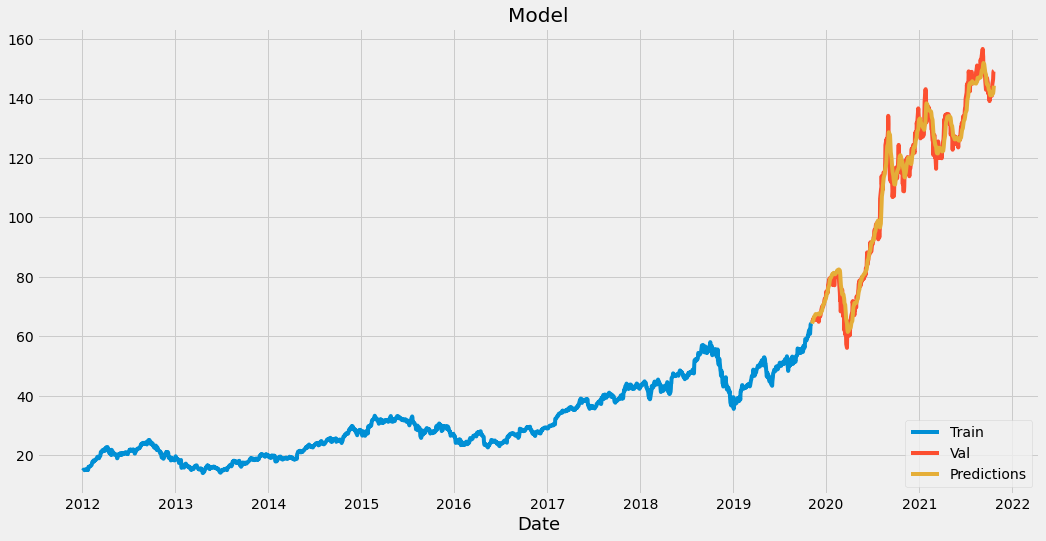

In [16]:
train = df.filter(['Close'])[:train_data_len]
valid = df.filter(['Close'])[train_data_len:]
valid['Predictions'] = predictions
#Visualize the data

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel=('Close Price USD ($)',18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()

In [17]:


apple_quote=web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end=today)
new_df = apple_quote.filter(['Close'])

last_100_days = new_df[-100:].values
last_100_days_scaled = scaler.fit_transform(last_100_days)


X_test = []

X_test.append(last_100_days_scaled)
X_test = np.array(X_test)
type(X_test)

numpy.ndarray

In [18]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

pred_price = model.predict(X_test)

pred_price =scaler.inverse_transform(pred_price)
print(pred_price)

[[146.6335]]
